## Data from sediment 
This notebook will focus on microbiome data collected from sediment of watertanks holding fish with different probiotic supplementation added

### Import and preprocessing

In [29]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

np.random.seed(111)
tf.random.set_seed(111)


In [30]:

kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Data/sed_bacteria_merged.csv')




In [32]:
df.head()

,pond,sample_id,ID,timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,S8,201,S8.201.Sed.S8,1,NaN,8.0,15.0,40.0,13.0,NaN,...,9.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,S8,202,S8.202.Sed.S8,2,NaN,256.0,297.0,170.0,103.0,NaN,...,13.0,32.0,23.0,15.0,15.0,13.0,12.0,11.0,11.0,NaN
2,S14,203,S14.203.Sed.S14,1,35.0,69.0,15.0,3.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S14,204,S14.204.Sed.S14,2,181.0,220.0,249.0,47.0,23.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S18,205,S18.205.Sed.S18,1,0.0,212.0,62.0,39.0,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
predictors = df.columns[4:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")
      
df['timepoint'] = LabelEncoder().fit_transform(df['timepoint'])
# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()

number of predictors/bacteria famillies: 227


,pond,sample_id,ID,timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,S8,201,S8.201.Sed.S8,0,0.0,8.0,15.0,40.0,13.0,0.0,...,9.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,S8,202,S8.202.Sed.S8,1,0.0,256.0,297.0,170.0,103.0,0.0,...,13.0,32.0,23.0,15.0,15.0,13.0,12.0,11.0,11.0,0.0
2,S14,203,S14.203.Sed.S14,0,35.0,69.0,15.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,S14,204,S14.204.Sed.S14,1,181.0,220.0,249.0,47.0,23.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,S18,205,S18.205.Sed.S18,0,0.0,212.0,62.0,39.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After the data look and checkup we can see that the dataset cosists of 227 bacteria famillies (columns) which we will treat as features, and 50 rows holding 25 unique values each of those represents one pond, ponds are divided into 5 different experimental setups we will have to decode that. Also there are two values per pond which indicate two points in time. We will perform classification between those two points to see if model is able to notice any significant changes and if it does use feature selection methods to see which bacteria is impacted by time alone regardless of supplementation. Later we will perform classification based on different experimental setups on both timepoints (one timepoint at the time) to see if there are changes between those.  

In [34]:
df.describe()

,sample_id,timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,225.50000,0.500000,87.880000,88.440000,238.540000,60.020000,13.140000,14.420000,17.660000,7.420000,...,0.440000,0.720000,0.460000,0.30000,0.900000,0.260000,0.240000,0.220000,0.220000,0.200000
std,14.57738,0.505076,72.437909,65.694767,359.278484,40.221068,21.783733,21.364753,24.860927,11.510581,...,2.214608,4.549232,3.252691,2.12132,4.704535,1.838478,1.697056,1.555635,1.555635,1.414214
min,201.00000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,213.25000,0.000000,32.000000,34.500000,24.000000,33.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,225.50000,0.500000,82.000000,73.500000,88.500000,56.500000,4.000000,2.000000,6.000000,1.500000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,237.75000,1.000000,126.250000,121.000000,297.000000,80.000000,19.500000,22.000000,28.000000,10.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,250.00000,1.000000,368.000000,256.000000,1898.000000,170.000000,103.000000,86.000000,113.000000,52.000000,...,13.000000,32.000000,23.000000,15.00000,30.000000,13.000000,12.000000,11.000000,11.000000,10.000000


In [35]:
# for normalisation we will use starndard min-max normalisation
df_norm = df.copy()
df_norm[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df_norm.describe()

,sample_id,timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,225.50000,0.500000,0.238804,0.345469,0.125680,0.353059,0.127573,0.167674,0.156283,0.142692,...,0.033846,0.022500,0.020000,0.020000,0.030000,0.020000,0.020000,0.020000,0.020000,0.020000
std,14.57738,0.505076,0.196842,0.256620,0.189293,0.236595,0.211493,0.248427,0.220008,0.221357,...,0.170354,0.142163,0.141421,0.141421,0.156818,0.141421,0.141421,0.141421,0.141421,0.141421
min,201.00000,0.000000,0.000000,0.011719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,213.25000,0.000000,0.086957,0.134766,0.012645,0.195588,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,225.50000,0.500000,0.222826,0.287109,0.046628,0.332353,0.038835,0.023256,0.053097,0.028846,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,237.75000,1.000000,0.343071,0.472656,0.156481,0.470588,0.189320,0.255814,0.247788,0.192308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,250.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))
df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))

C:\Users\marek\AppData\Local\Temp\ipykernel_6436\359795458.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm['class_pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes))


In [37]:
df = df.copy()

### Modeling timepoints only

Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

#### Model building


In [10]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
#model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(2, activation ='softmax'))


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 2
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 0.0216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted classes:       [0 0 1 1 0 1 1 0 1 0]
true validation classes: [0 0 1 1 0 1 1 0 1 0]
mean confidence score: 311391.776, sd confidence score: 778732.078
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [1 0 1 1 1 1 0 0 1 0]
true validation classes: [1 0 1 1 1 1 0 0 1 0]
mean confidence score: 2001368.5749, sd confidence score: 4114829.0025
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9000 - loss: 0.2033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [1 0 0 1 1 1 1 0 1 1]
true validation classes: [1 0 0 1 1 0 1 0 1 1]
mean confidence score: 150123914.7316, sd confidence score: 396141561.5038
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 

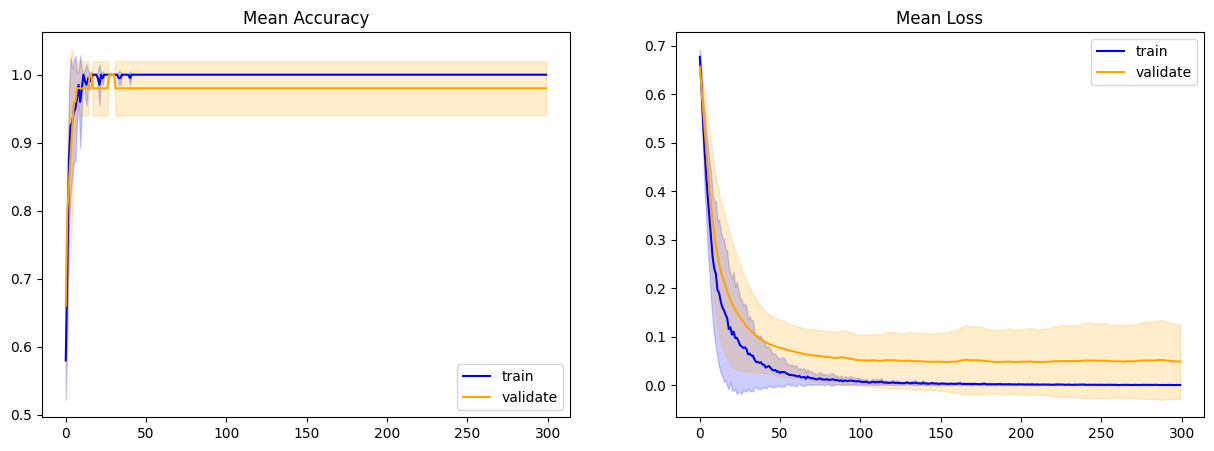

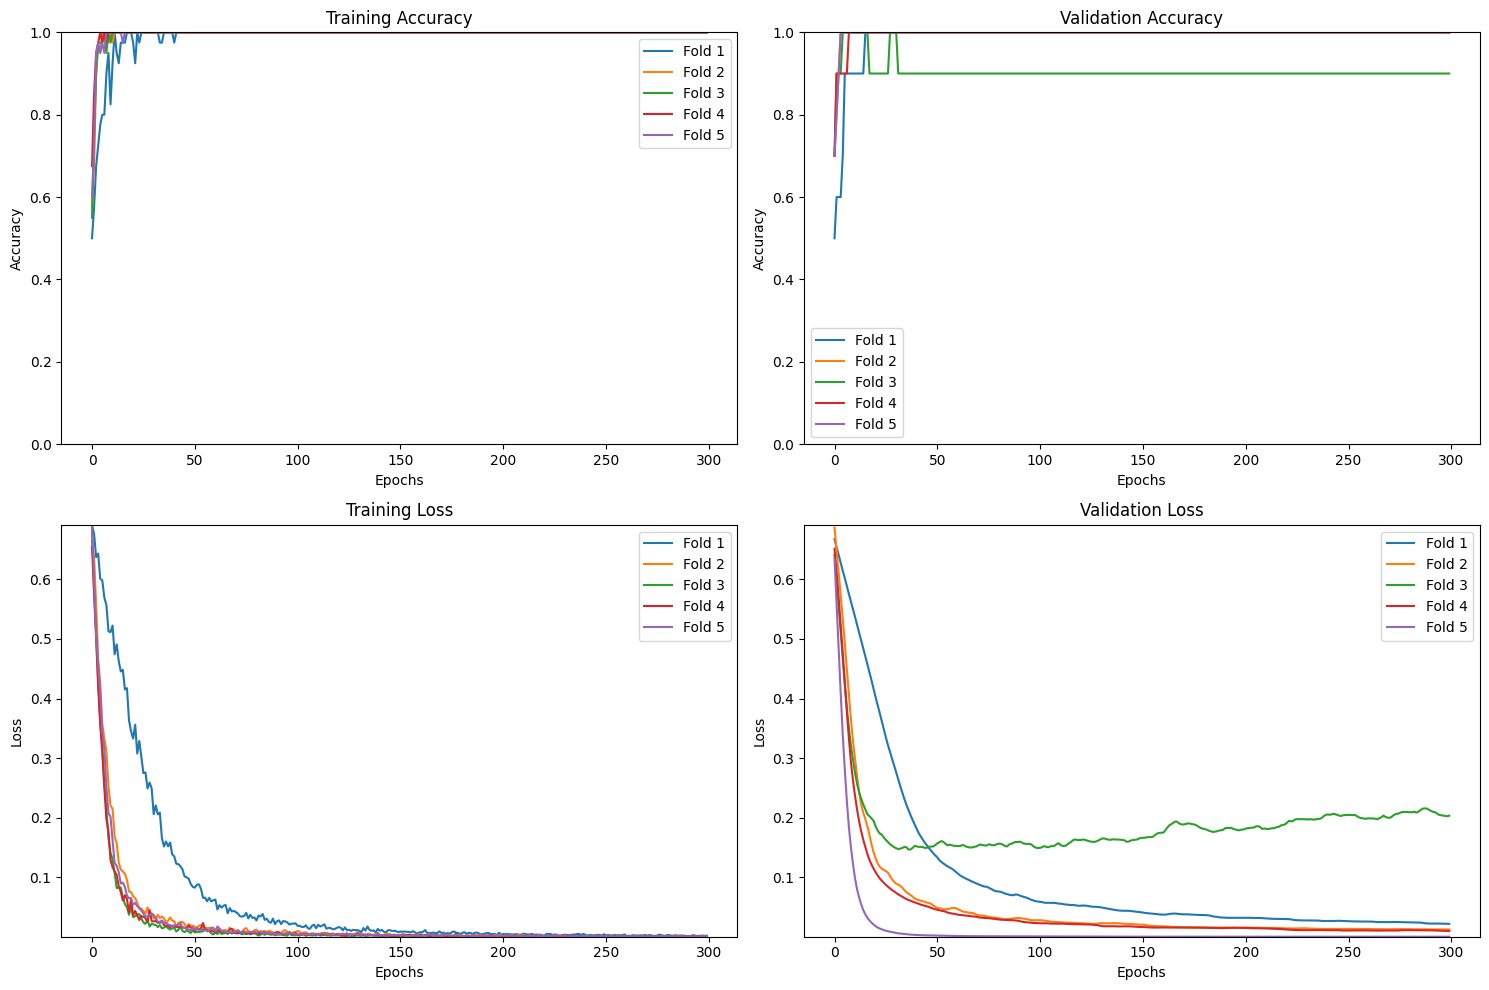

In [11]:
crossvalidate(df_norm, model1, predictors, "timepoint", kf)

We can see that model is not suffering from overfitting problem, and the accuracy is perfect with 1 in almost all folds. This prooves that there are siginifcant enough differences in timepoints that the model is able to classify them correctly.

We will now try to classify based only on different experimental setups. 

### Modeling differences between Classes for both timepoints at the same time

In [13]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4000 - loss: 2.8006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
predicted classes:       [4 1 1 3 2 2 3 4 4 4]
true validation classes: [0 1 1 2 3 3 3 3 3 4]
mean confidence score: 10.0957, sd confidence score: 7.5121
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1000 - loss: 4.4445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [4 1 3 4 3 3 1 4 2 4]
true validation classes: [0 0 0 1 1 2 3 4 4 3]
mean confidence score: 34.1242, sd confidence score: 56.2313
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3000 - loss: 2.6353
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 4 3 0 4 2 2 1 0 4]
true validation classes: [0 0 0 1 2 2 2 3 3 4]
mean confidence score: 10.2533, sd confidence score: 17.1372
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5000 - loss: 1.8043
1/1 ━━━━━━━━━━━━━━━━━━━━

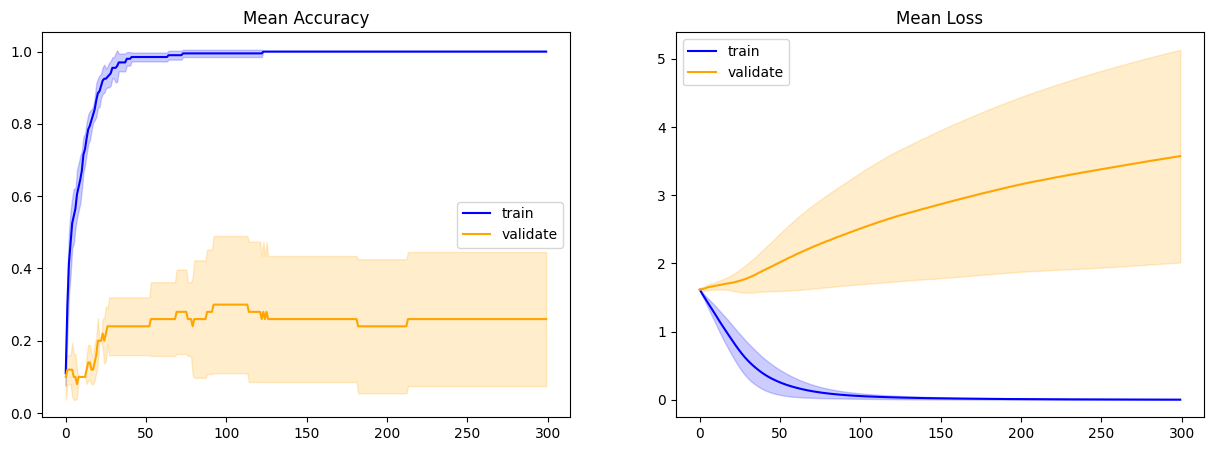

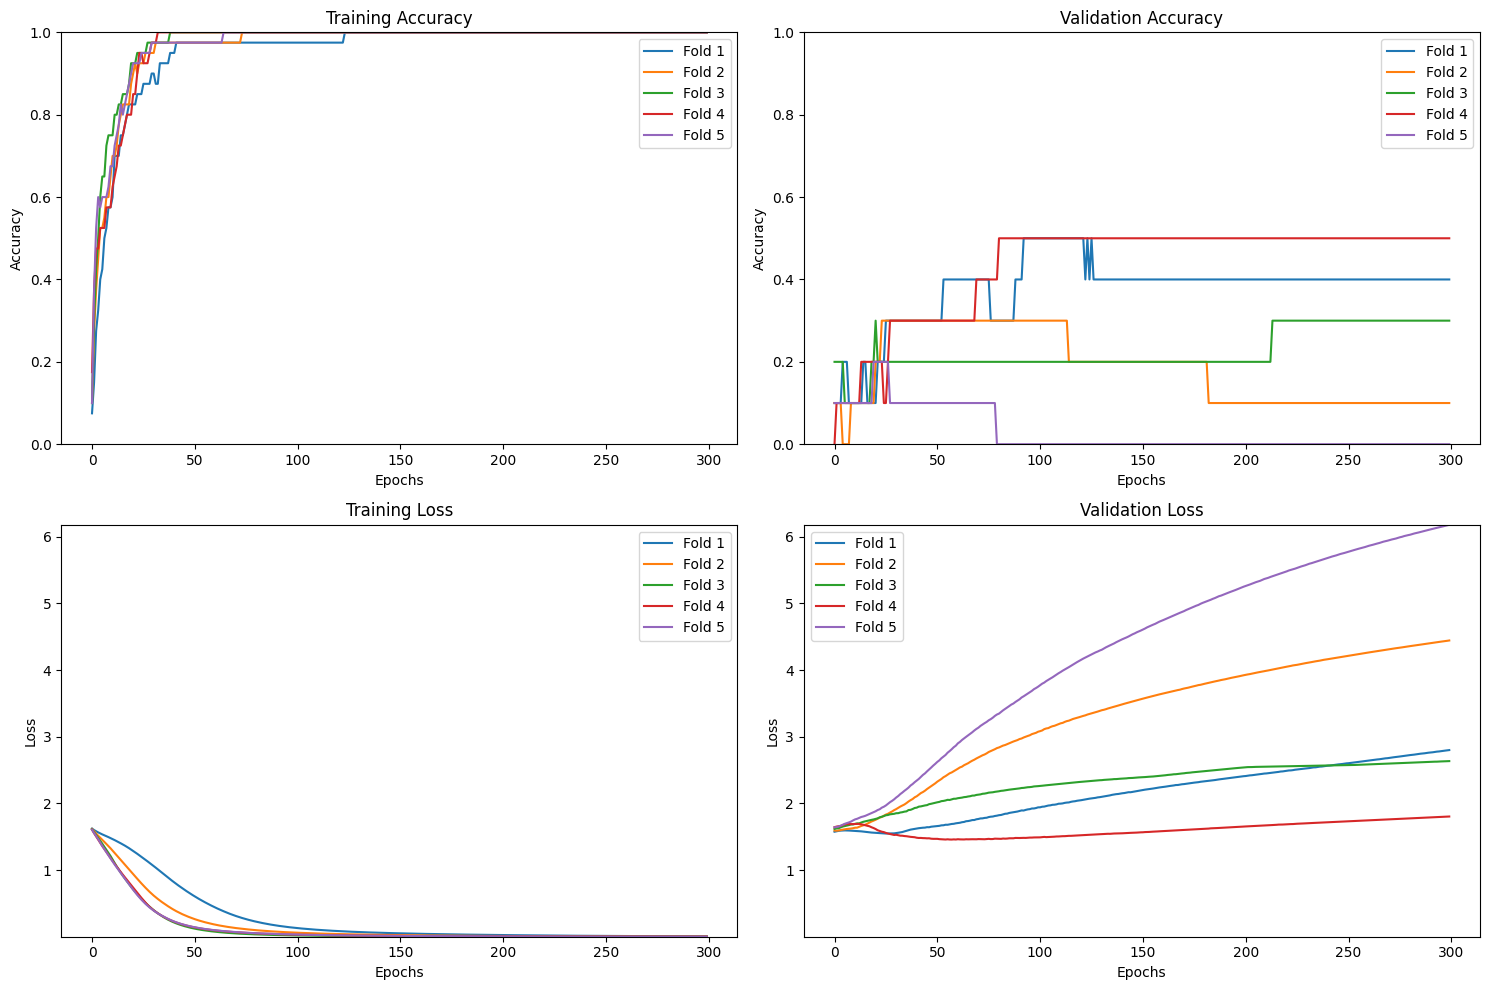

In [14]:
crossvalidate(df_norm, model2, predictors, "class_pond", kf)

Not normalised dataset

Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6000 - loss: 3.5621
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 3 1 2 3 2 3 4 4 4]
true validation classes: [0 1 1 2 3 3 3 3 3 4]
mean confidence score: 2506475697707663.5, sd confidence score: 7519427093122171.0
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2000 - loss: 7.4480
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [3 4 4 3 3 3 3 4 3 4]
true validation classes: [0 0 0 1 1 2 3 4 4 3]
mean confidence score: 565139.292, sd confidence score: 1691074.2179
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3000 - loss: 8.7231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [0 0 3 0 0 4 4 1 0 4]
true validation classes: [0 0 0 1 2 2 2 3 3 4]
mean confidence score: 2363280742.1052, sd confidence score: 7089841714.965
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0

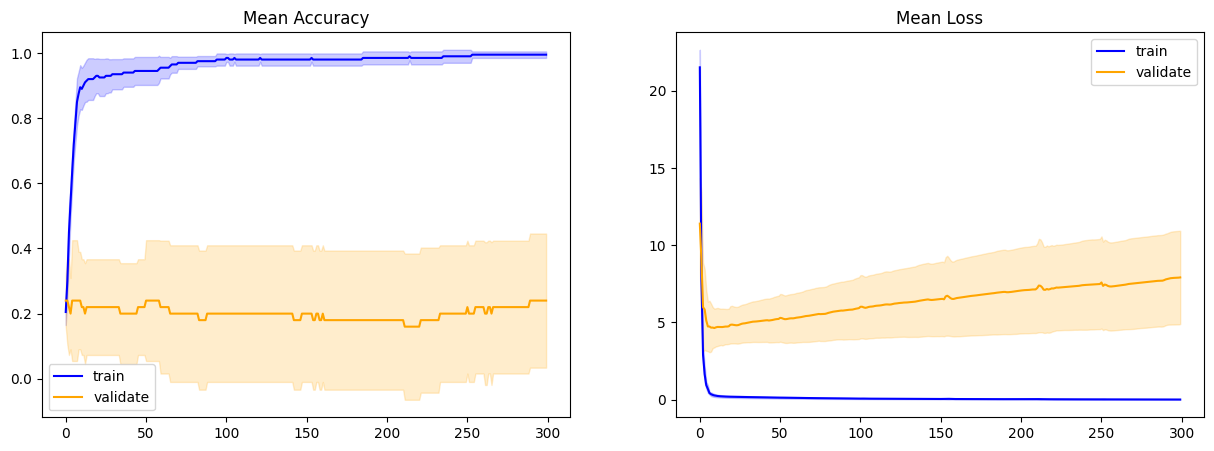

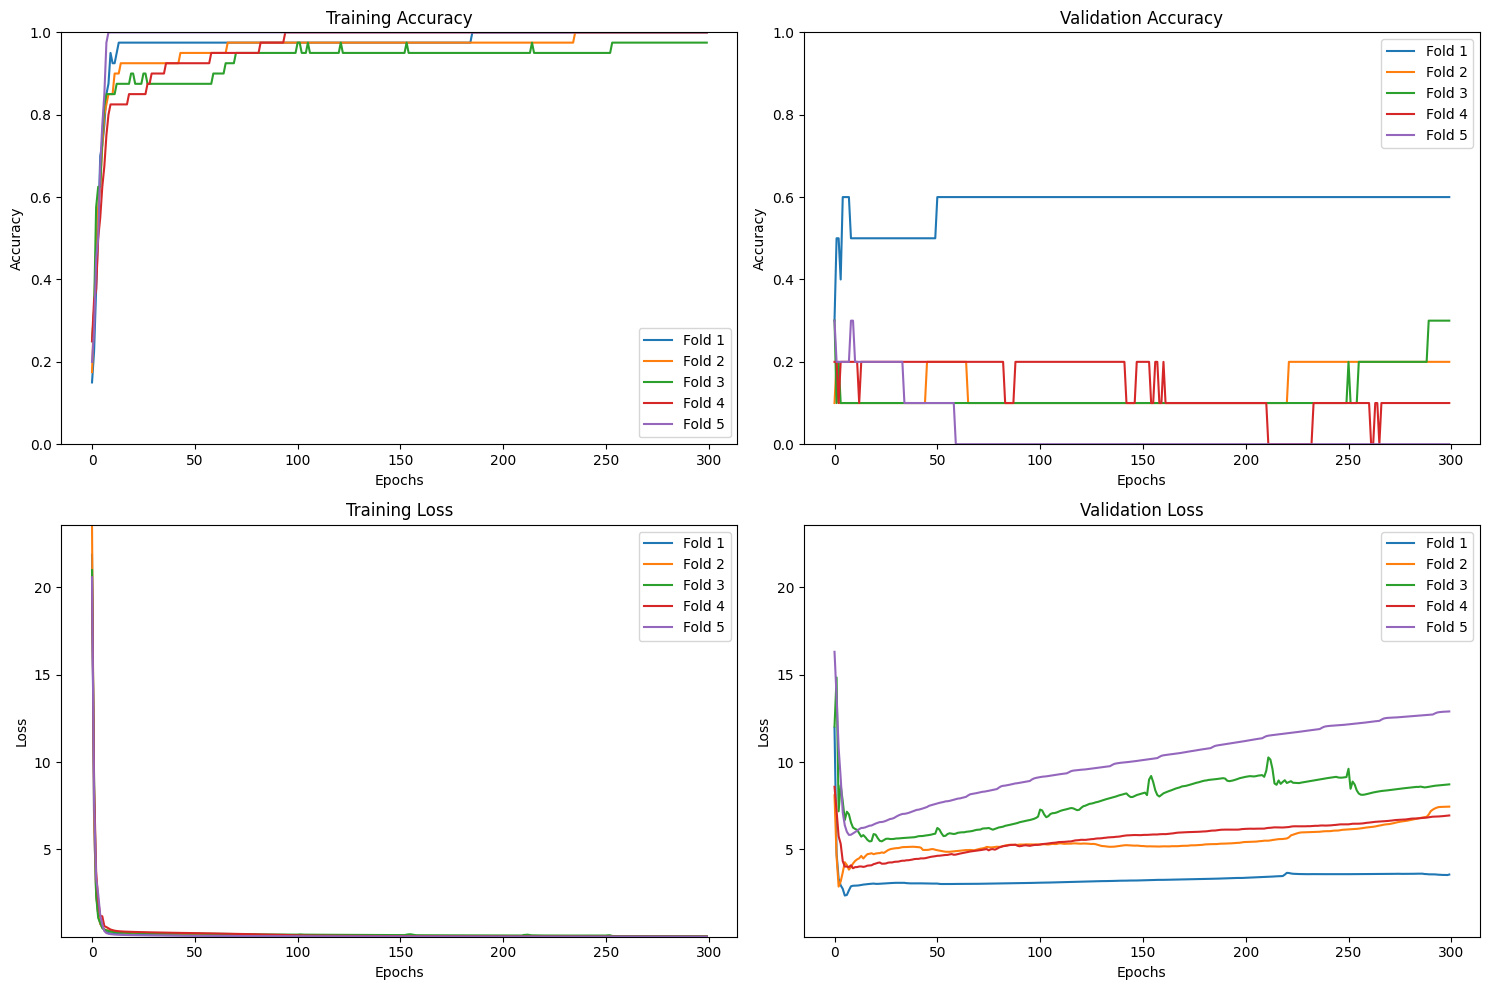

In [15]:
crossvalidate(df, model2, predictors, "class_pond", kf)

Here we can note that the results are much worse, overfitting is happening quite fast and accuracy barely reaches above 0.2 wchich is the random score for both normalized and not normalized datasets. This probably because we didnt account on differences in timepoints which prooved to be crucial on previous classification. We will now move to classify differences in second and first timepoint. obvious issue will be that we will halve our number of samples.


### Modeling class differences in first timepoint

In [20]:
df_first_tp = df_norm[df_norm["timepoint"]==0]
print(df_first_tp.shape)
df_first_tp.head()

(25, 232)


,pond,sample_id,ID,timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
0,S8,201,S8.201.Sed.S8,0,0.000000,0.031250,0.007903,0.235294,0.126214,0.000000,...,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,S14,203,S14.203.Sed.S14,0,0.095109,0.269531,0.007903,0.017647,0.000000,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,S18,205,S18.205.Sed.S18,0,0.000000,0.828125,0.032666,0.229412,0.194175,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,S24,207,S24.207.Sed.S24,0,0.035326,0.406250,0.005269,0.241176,0.135922,0.000000,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,S29,209,S29.209.Sed.S29,0,0.489130,0.472656,0.092202,0.670588,0.000000,0.197674,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2000 - loss: 2.3351
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
predicted classes:       [4 3 3 3 3]
true validation classes: [0 0 2 2 3]
mean confidence score: 3.9879, sd confidence score: 1.4019
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2000 - loss: 2.8385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [0 3 1 3 0]
true validation classes: [1 1 2 3 3]
mean confidence score: 3.3763, sd confidence score: 1.4897
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.0000e+00 - loss: 2.5914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
predicted classes:       [4 4 3 1 2]
true validation classes: [0 0 2 3 4]
mean confidence score: 7.648, sd confidence score: 8.5142
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.0000e+00 - loss: 2.2392
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predicted classes:       [4 2 3 3 0]
true va

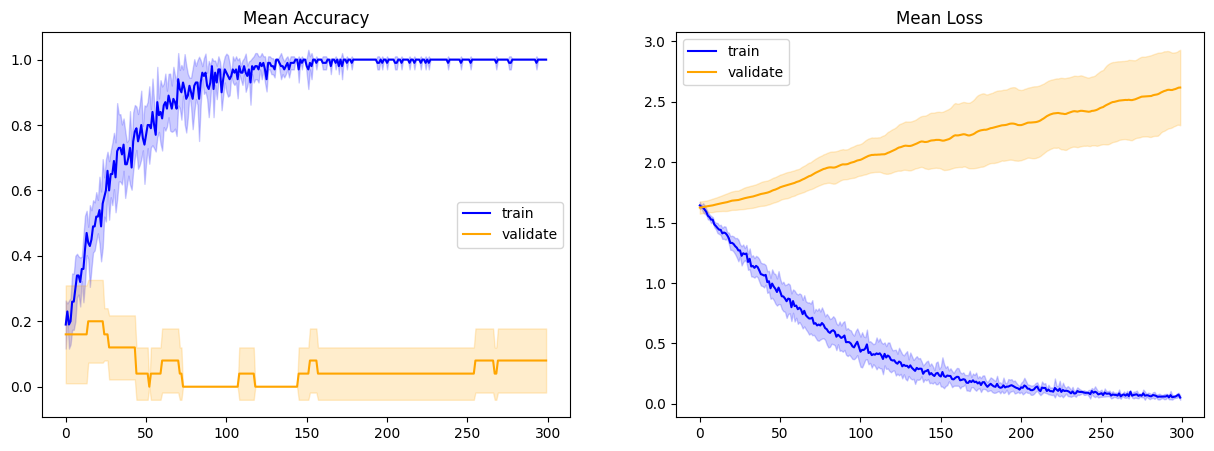

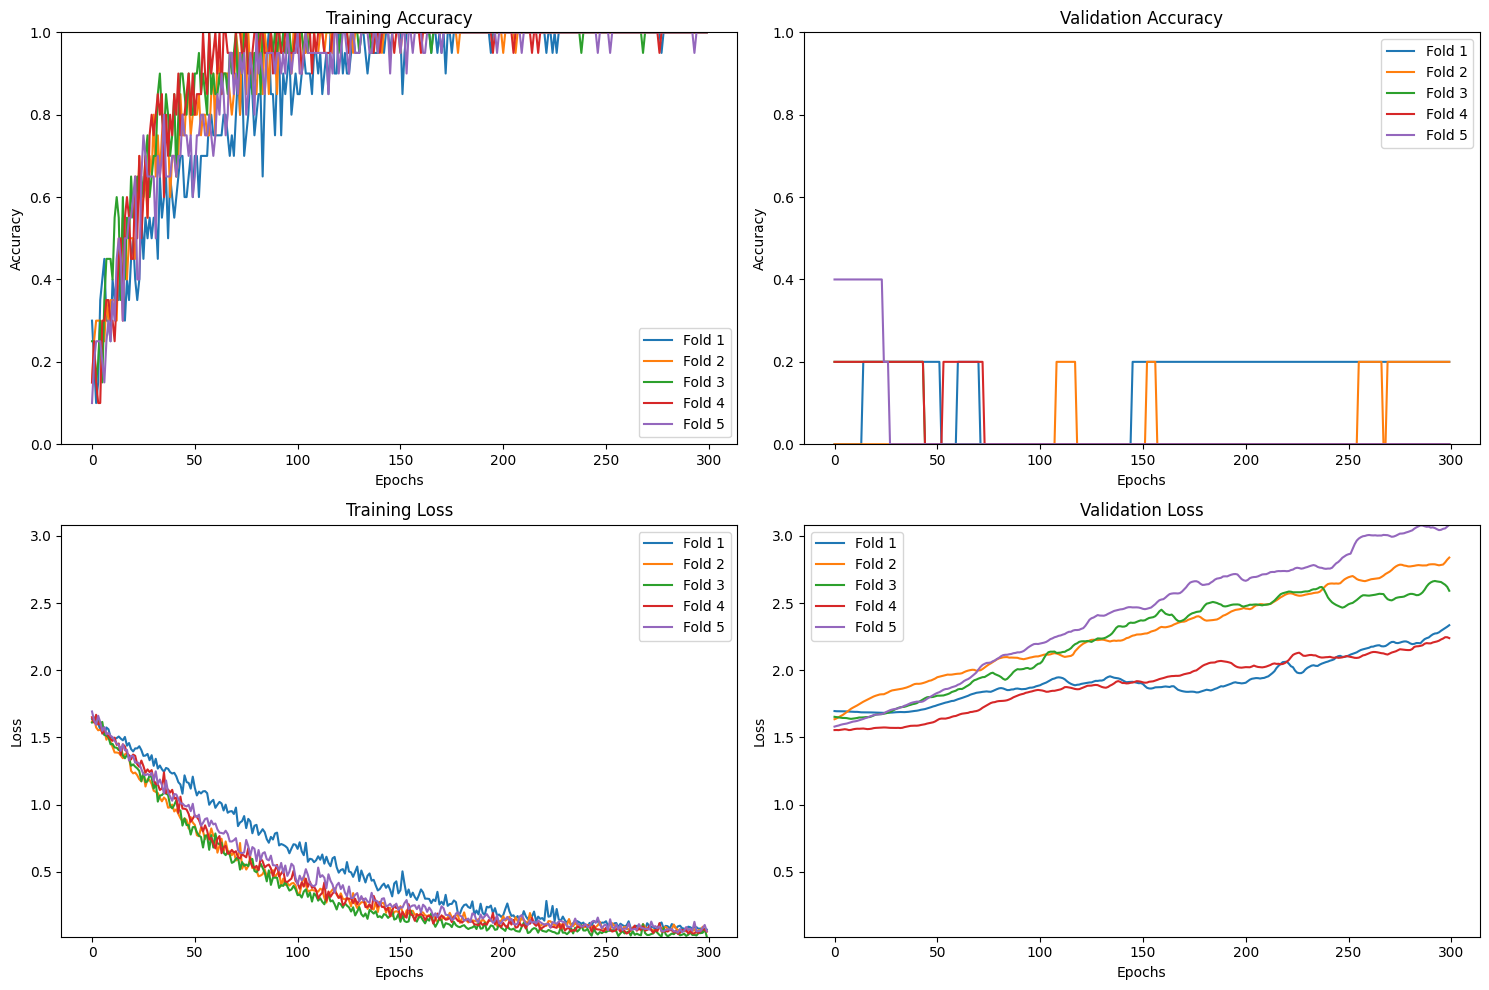

In [22]:
crossvalidate(df_first_tp, model3, predictors, "class_pond", kf)

### Modeling class differences in second timepoint

In [17]:
df_second_tp = df_norm[df_norm["timepoint"]==1]
print(df_second_tp.shape)
df_second_tp.head()

(25, 232)


,pond,sample_id,ID,timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,class_pond
1,S8,202,S8.202.Sed.S8,1,0.000000,1.000000,0.156481,1.000000,1.000000,0.000000,...,1.0,1.0,1.0,0.5,1.0,1.0,1.0,1.0,0.0,0
3,S14,204,S14.204.Sed.S14,1,0.491848,0.859375,0.131191,0.276471,0.223301,0.488372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,S18,206,S18.206.Sed.S18,1,0.127717,0.011719,0.144362,0.317647,0.126214,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,S24,208,S24.208.Sed.S24,1,0.241848,0.113281,0.054268,0.588235,0.203883,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,S29,210,S29.210.Sed.S29,1,0.296196,0.125000,0.168599,0.147059,0.000000,0.337209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [18]:
model3 = keras.Sequential()



model3.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(5, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0000e+00 - loss: 3.1178
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
predicted classes:       [1 4 1 3 1]
true validation classes: [0 0 2 2 3]
mean confidence score: 7.5027, sd confidence score: 7.1315
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2000 - loss: 2.3262
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [4 4 2 4 4]
true validation classes: [1 1 2 3 3]
mean confidence score: 7.0045, sd confidence score: 6.8807
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2000 - loss: 2.5550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [1 4 1 3 2]
true validation classes: [0 0 2 3 4]
mean confidence score: 4.0508, sd confidence score: 3.2246
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2000 - loss: 2.8699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
predicted classes:       [0 0 4 4 2]
true valid

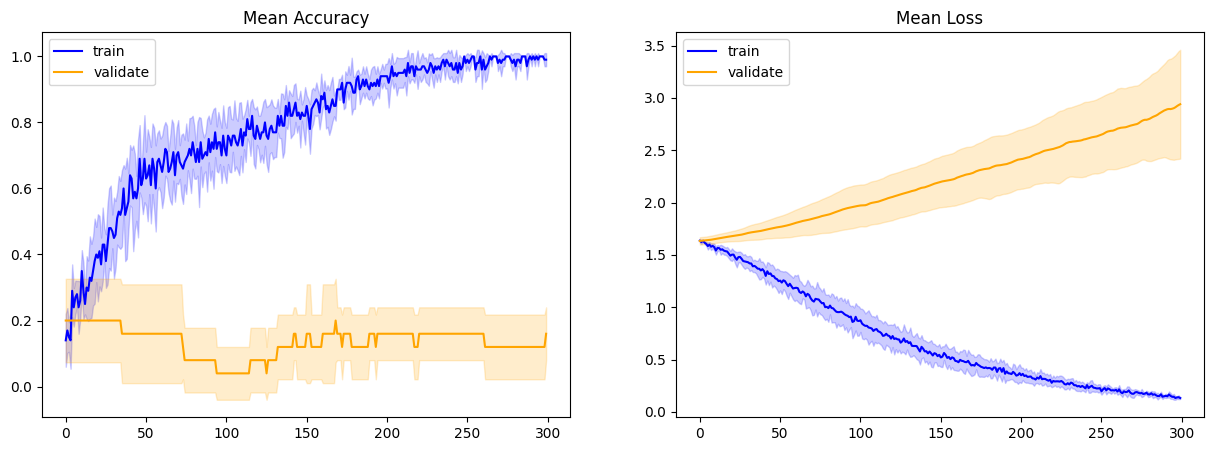

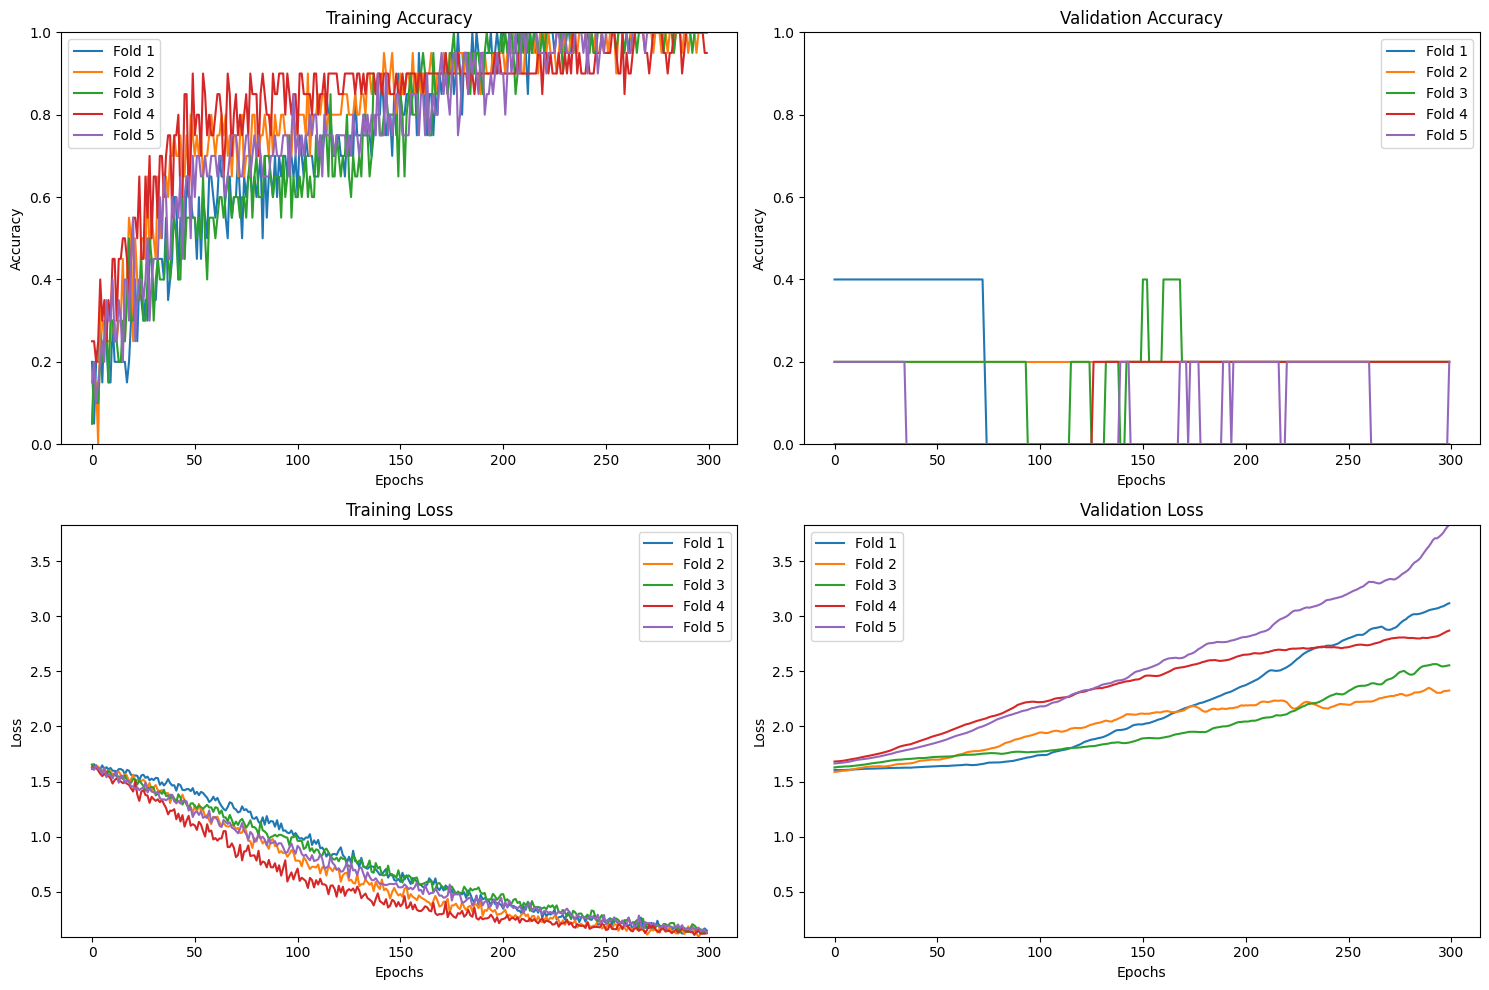

In [19]:
crossvalidate(df_second_tp, model3, predictors, "class_pond", kf)

From those results we can clearly see that its very hard to work with neural networks on such small sample sizes even when we choose to have 20 samples aviable for training the results were bad. We can also check how the model behaves when we split data into 10 classes (timepoint*experimetnal_setup)

### Modeling for Experimental setup and timepoint

In [23]:
df["class_timepointXpond"] = df["timepoint"].astype(str) + "_" + df["class_pond"].astype(str)
df_norm["class_timepointXpond"] = df["timepoint"].astype(str) + "_" + df["class_pond"].astype(str)

C:\Users\marek\AppData\Local\Temp\ipykernel_6436\1702750723.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm["class_timepointXpond"] = df["timepoint"].astype(str) + "_" + df["class_pond"].astype(str)


In [24]:
df_norm["class_timepointXpond_encoded"] = LabelEncoder().fit_transform(df_norm["class_timepointXpond"])
df_norm["class_timepointXpond_encoded"] = df_norm["class_timepointXpond_encoded"].astype(int)

C:\Users\marek\AppData\Local\Temp\ipykernel_6436\3234183536.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_norm["class_timepointXpond_encoded"] = LabelEncoder().fit_transform(df_norm["class_timepointXpond"])


In [25]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(10, activation ='softmax'))

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Number of classes: 10
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4000 - loss: 2.3512
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
predicted classes:       [4 1 6 7 2 7 8 1 5 0]
true validation classes: [0 1 6 7 3 8 8 3 8 4]
mean confidence score: 20.3122, sd confidence score: 17.2718
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1000 - loss: 3.2235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predicted classes:       [9 3 8 9 1 8 2 4 7 4]
true validation classes: [5 0 5 6 6 7 3 4 9 3]
mean confidence score: 158.2854, sd confidence score: 435.9419
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3000 - loss: 3.6891
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [5 4 2 6 9 1 7 1 7 5]
true validation classes: [5 0 0 6 7 2 7 3 8 9]
mean confidence score: 260.6794, sd confidence score: 746.2606
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1000 - loss: 3.8473
1/1 ━━━━━━━━━━━━━━

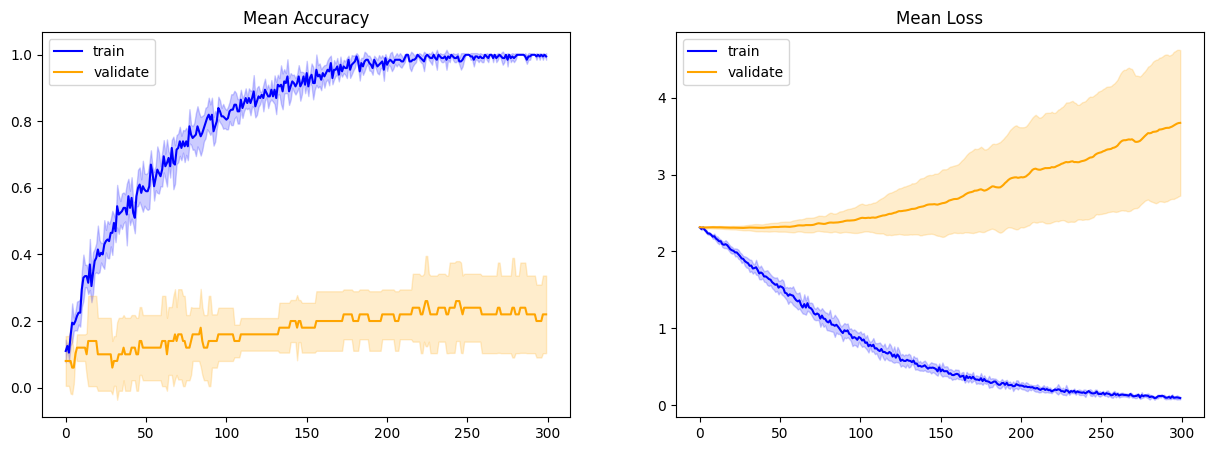

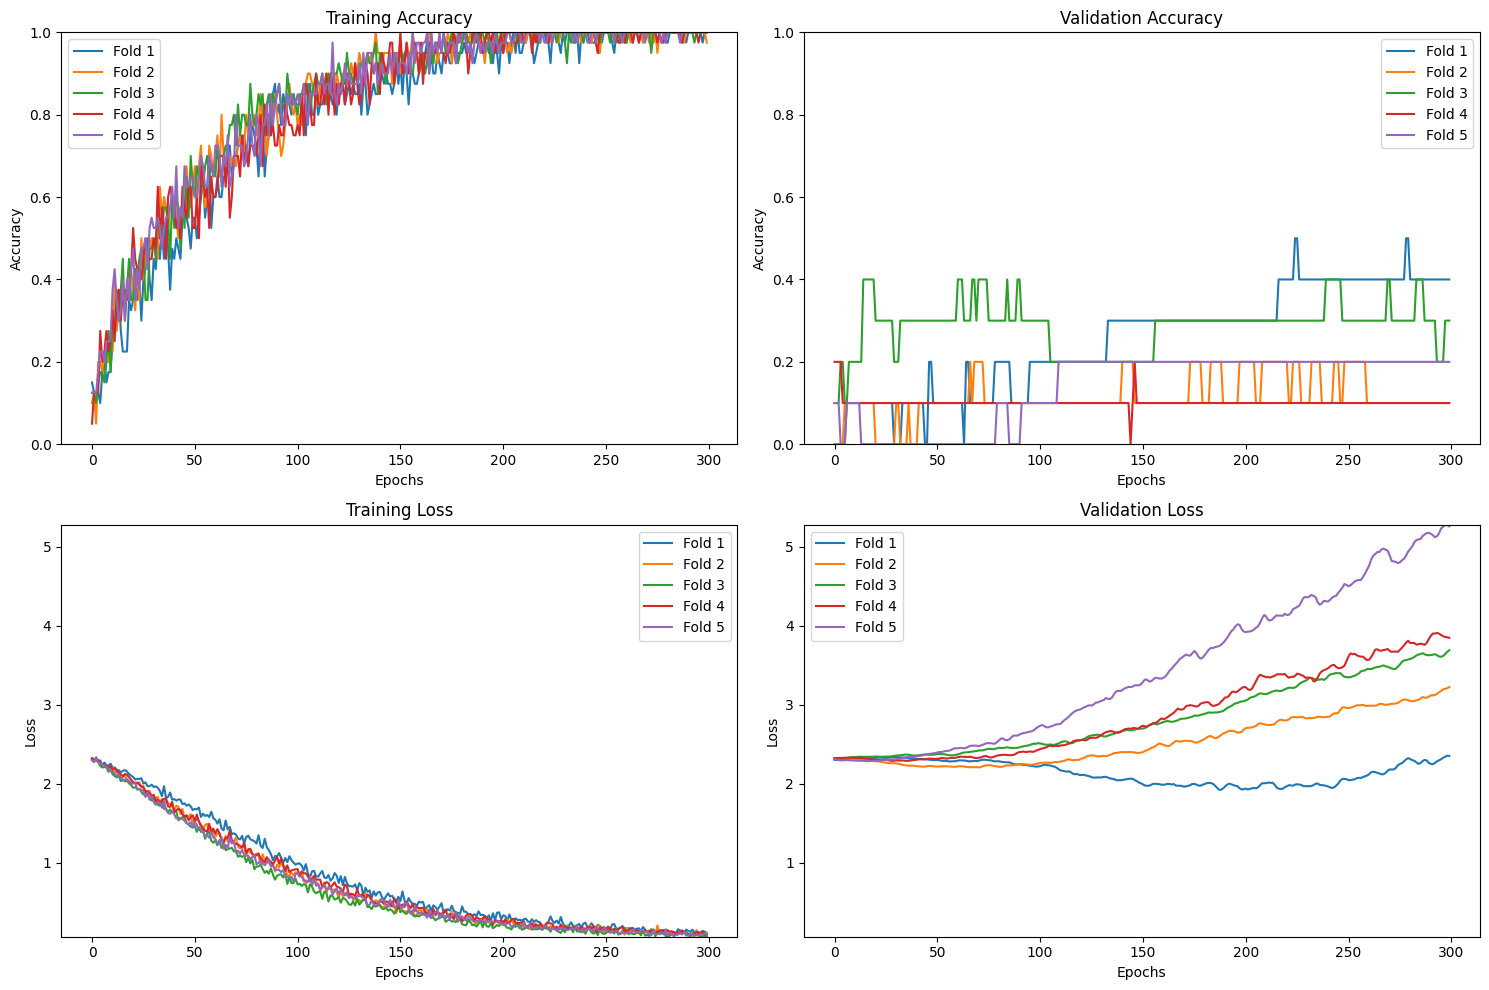

In [26]:
crossvalidate(df_norm, model4, predictors, "class_timepointXpond_encoded", kf)

In [27]:
df["class_timepointXpond_encoded"] = LabelEncoder().fit_transform(df["class_timepointXpond"])
df["class_timepointXpond_encoded"] = df["class_timepointXpond_encoded"].astype(int)

Number of classes: 10
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3000 - loss: 3.1038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [3 1 6 6 7 9 6 1 6 4]
true validation classes: [0 1 6 7 3 8 8 3 8 4]
mean confidence score: 10.9779, sd confidence score: 17.1537
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2000 - loss: 5.2798
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted classes:       [7 1 6 2 1 7 1 4 7 4]
true validation classes: [5 0 5 6 6 7 3 4 9 3]
mean confidence score: 200889.2869, sd confidence score: 597835.7693
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3000 - loss: 3.4522
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [5 3 1 8 9 7 7 1 7 9]
true validation classes: [5 0 0 6 7 2 7 3 8 9]
mean confidence score: 421.6299, sd confidence score: 940.1751
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.1000 - loss: 7.5490
1/1 ━━━━━━━━━

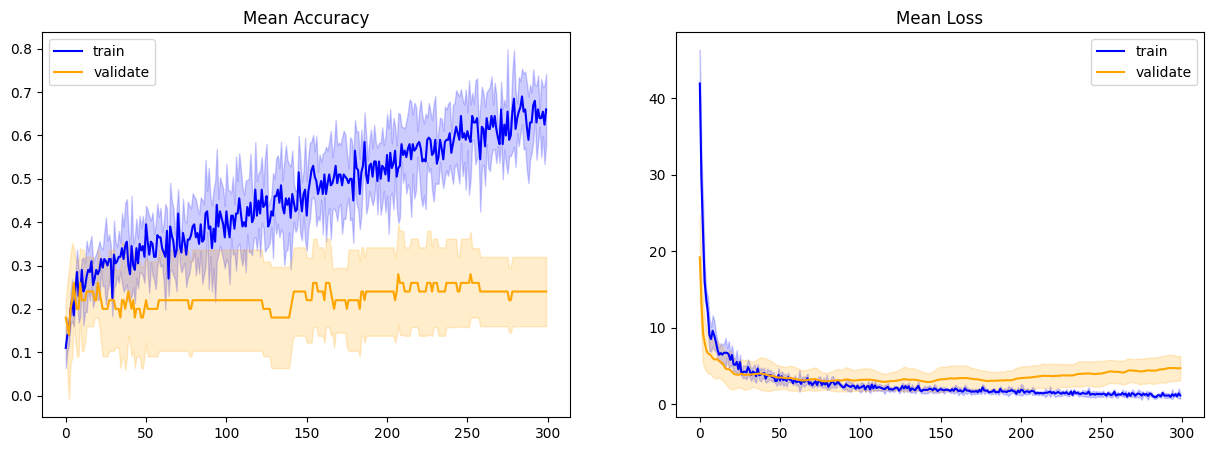

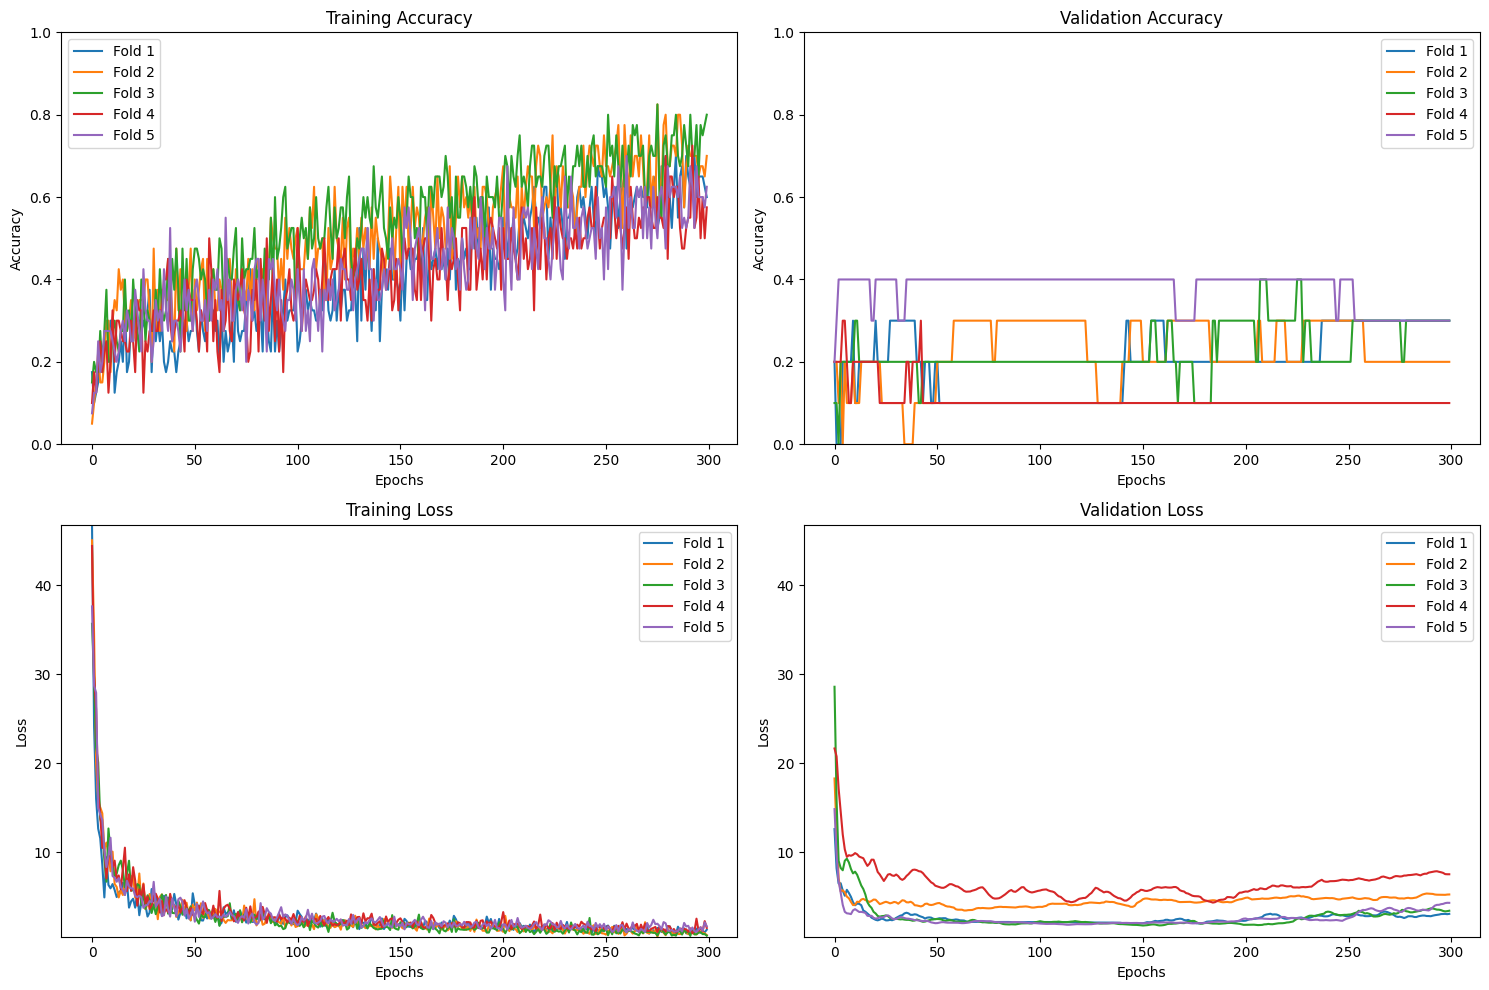

In [28]:
crossvalidate(df, model4, predictors, "class_timepointXpond_encoded", kf)

Although we dont see signs of overfitting accuracy is lackluster either, close to random. Probable casue of that is that although there are differencecs in timepoints there are really no differences in exprimental setups. So trying to classify timepointsXponds didntt really result in anything. We will now in the next notebook try to change classes for experimental setups a bit as we done in gut analysis. 